# Table of contents
1. [Requirements](#Requirements)
2. [Introduction](#Introduction)
3. [Imports](#Imports)
    1. [Libraries](#Libraries)
    2. [Data](#Data)
4. [Data Exploration](#data-exploration)
5. [Modelling](#modelling)
    1. [Baseline](#baseline)
    2. [LSTM](#lstm)
6. [Results Analysis](#results-analysis)

# Requirements

In [76]:
!pip install keras-tuner

In [77]:
!pip install --upgrade holidays

## Introduction

## Imports

### Libraries


In [78]:
import sympy
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import numpy as np
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
from datetime import datetime

In [79]:
import matplotlib.pyplot as plt
import holidays
import seaborn as sns

### Data

In [80]:
# Load the data
worksheet_EnergyConsumption = pd.read_csv('consumption.csv')
worksheet_Weather = pd.read_csv('weather.csv')

In [81]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table


In [82]:
missing_zero_values_table(worksheet_EnergyConsumption)

Your selected dataframe has 8 columns and 43823 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
PT_wind_generation_actual,0,43823,100.0,43823,100.0,float64
PT_wind_offshore_generation_actual,0,43823,100.0,43823,100.0,float64
PT_solar_generation_actual,20263,8,0.0,20271,46.3,float64
PT_load_actual_entsoe_transparency,0,1,0.0,1,0.0,float64
PT_load_forecast_entsoe_transparency,0,1,0.0,1,0.0,float64
PT_wind_onshore_generation_actual,0,1,0.0,1,0.0,float64


In [83]:
missing_zero_values_table(worksheet_Weather)

Your selected dataframe has 4 columns and 43823 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [84]:
# Transform timestamp datatype
worksheet_EnergyConsumption["utc_timestamp"] = pd.to_datetime(worksheet_EnergyConsumption["utc_timestamp"])
worksheet_Weather["utc_timestamp"] = pd.to_datetime(worksheet_Weather["utc_timestamp"])

# As seguintes colunas estão todas NaN, não são uteis. The remaining columns are removed since they aren't usefull.
worksheet_EnergyConsumption.drop([
    "cet_cest_timestamp",
    "PT_wind_generation_actual",
    "PT_wind_offshore_generation_actual",
    "PT_wind_onshore_generation_actual",
    "PT_solar_generation_actual"
], axis=1, inplace=True)

# Bfill 
worksheet_EnergyConsumption["PT_load_forecast_entsoe_transparency"] = worksheet_EnergyConsumption["PT_load_forecast_entsoe_transparency"].bfill()
worksheet_EnergyConsumption["PT_load_actual_entsoe_transparency"] = worksheet_EnergyConsumption["PT_load_actual_entsoe_transparency"].bfill()


In [86]:
pt_holidays=holidays.country_holidays('PT')
worksheet_EnergyConsumption['isHoliday']=pd.Series(worksheet_EnergyConsumption.index).apply(lambda x: holidays.country_holidays('PT').get(x)).values.astype('bool').astype('int')

In [87]:
df=pd.merge(worksheet_EnergyConsumption, worksheet_Weather, on="utc_timestamp")

In [88]:
# Timestamps are very usefull as inputs for modelling purposes, especially when using time series.
# If there is peridiocity within the physical phenomena which generates the feature we're measuring, then to use the "timestamp" we must transform the data into a "readable format" for the model, not this string-like form.
# Therefore, we can transform this timeperiod into a "signal" - the sine and cosine transforms. This signal, represented by sin and cosin waves will "emulate" the "time of the day" and "of the year" as usable signals/data.
# Being weather and energy consumption data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.
date_time=worksheet_EnergyConsumption["utc_timestamp"].copy()
timestamp_s=date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


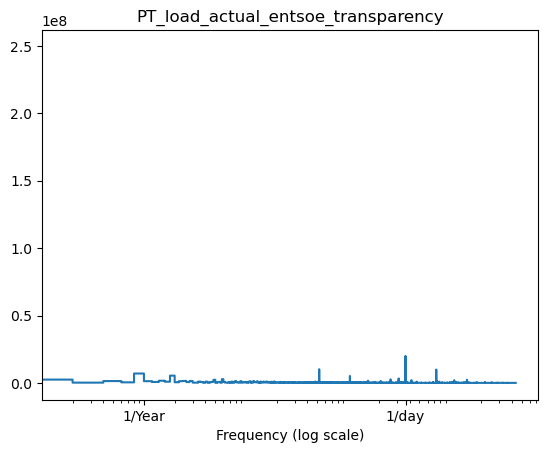

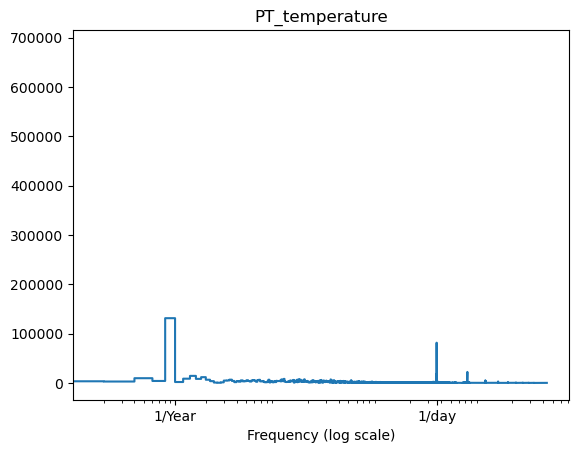

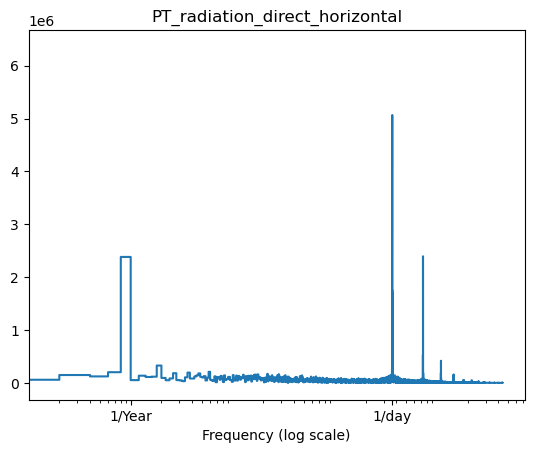

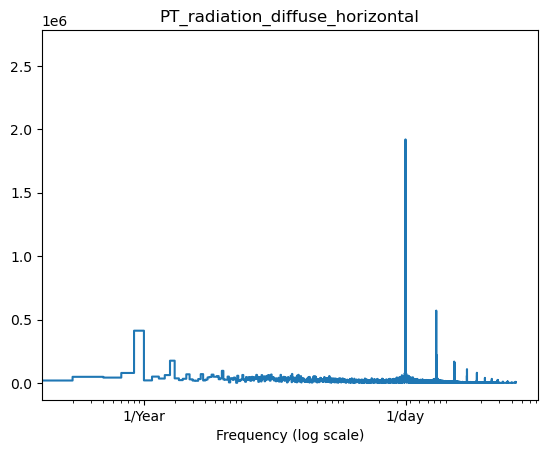

In [89]:
# para confirmar a periocidade diária e anual através da FFT: (Transformada de Fourier - explicar um pouco o que é?)
# COMMENT: After a carefull look at the results we can clearly observe and confirm our assumptions: 
# both yearly and daily periodiocity exist. However, a intra-daily peridiocity also is highlighted in the graphs,
# especially in the features which concern radiation. This intra-day is explained by the "solar cycle", the time of the day.  
def plot_fft(df):
    columns=df.columns
    for col in columns:
        values=df[col].values
        fft=np.fft.fft(values)
        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = len(df[col])
        hours_per_year = 24*365.2524
        years_per_dataset = n_samples_h/(hours_per_year)

        f_per_year = f_per_dataset/years_per_dataset
        plt.figure()
        plt.step(f_per_year, np.abs(fft))
        plt.xscale('log')
        
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
        _ = plt.xlabel('Frequency (log scale)')
        plt.title(col)

    plt.show()
df_copy=df.loc[:,["PT_load_actual_entsoe_transparency","PT_temperature","PT_radiation_direct_horizontal","PT_radiation_diffuse_horizontal"]]
plot_fft(df_copy)

In [90]:
df=df.set_index('utc_timestamp')

In [93]:
# Splitting the data -
# slicing the data for
# - Training : [2015-2017]
# - Test: [2018]
# - Validation [2019]
# COMMENTS: 
# Em timeseries forecasting pode-se fazer é testar os modelos com splits diferentes, para fazer cross validation dos datasets utilizados. Caso contrário podemos cair no erro de seleccionar o melhor modelo, randomly.

df_train=df.loc['2015':'2017'].copy()
df_test=df.loc['2018'].copy()
df_validation=df.loc['2019'].copy()


In [94]:
# Normalize the data
# The normalization should not consider the time-series/features within the test and validation sets. 
# Hence, "the mean and standard deviation should only be computed using the training data 
# so that the models have no access to the values in the validation and test sets."
# ref- https://www.tensorflow.org/tutorials/structured_data/time_series
train_mean = df_train.mean()
train_std = df_train.std()

train_df = (df_train - train_mean) / train_std
val_df = (df_validation - train_mean) / train_std
test_df = (df_test - train_mean) / train_std

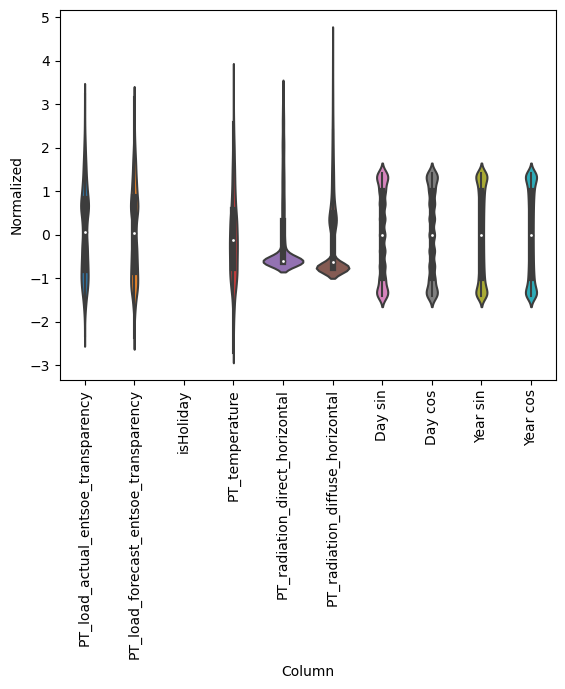

In [97]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


## Data Exploration

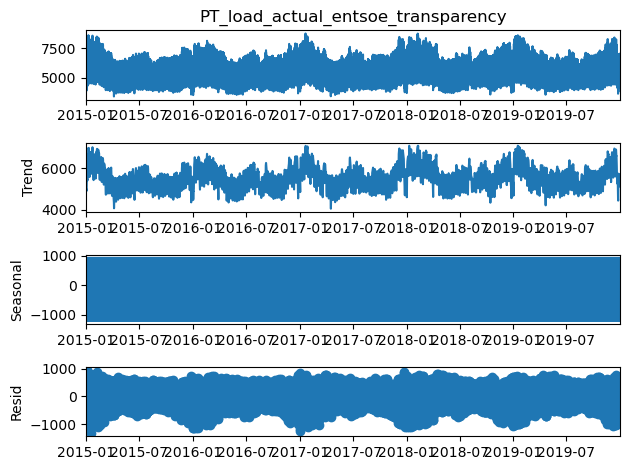

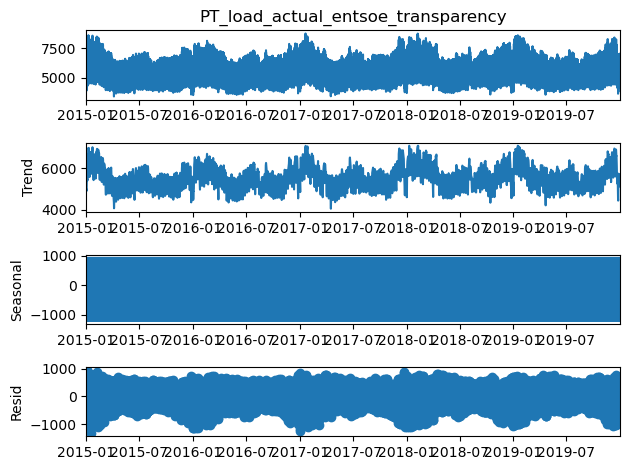

In [98]:
# Para tentar "completar" esta secção podemos fazer uns plots bónitos dos perfis de consumo e temperatura e radiação
# Podemos também decompor estas em perfis sazonais, diários, semanais, mensais, etc.
# AKA Timeseries decomposition através da statsmodel
# - Seasonal
# - Autocorrelation function (acf)
# - Partial Autocorrelation function (PACF)
# refs & exemplos - https://neptune.ai/blog/select-model-for-time-series-prediction-task

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['PT_load_actual_entsoe_transparency'])
result.plot()

## Modelling

In [ ]:
# # Aqui tratar de qualquer operação ou criação de variáveis que sejam
# # necessárias para o processo de modelação de DL.
# # Number of samples
# n_samples = len(hourly_energy_consumption)

# # Number of time steps
# n_timesteps = 24
# # Number of features
# n_features = 3
# # Reshape the data into a 3D array to feed the Neural Netwokrs
# X = np.empty((n_samples, n_timesteps, n_features))
# X[:, :, 0] = hourly_energy_consumption
# X[:, :, 1] = hourly_temperature
# X[:, :, 2] = hourly_radiation

In [100]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [102]:
out_steps = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=out_steps,
                               shift=out_steps)

multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

### Baseline
        Persistence

A persistência é o método de baseline mais condiserado e que, como o nome indica, considera que o valor para o futuro é igual à ultima observação. Pode ser denotado pela seguinte equação:

$ T_{t+1} = T_{t} $ 

In [ ]:
# creating the persistence matrix
# df.merged.shape should be Amount of predictions we want to gather X 24
persistence_forecasts=np.zeros((dfmerged.shape),dtype=float)
for i in range(len(dfmerged)):
    persistence_forecasts.iloc[i,:]=dfmerged.iloc[i,-1]

### LSTM

In [ ]:
# Define the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(24))
    
    # Choose an optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd','rmsprop'])
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    else:    
        optimizer = tf.keras.optimizers.RMSprop(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
        
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
# Define the search space for Keras Tuner
hps = HyperParameters()
hps.Choice('batch_size', [32, 64, 128, 256])
hps.Choice('activation', ['relu', 'tanh','sigmoid'])
# Use the Keras Tuner to search for the best set of hyperparameters
tuner = kt.Hyperband(build_model, hps)
tuner.search(X_train, y_train, epochs=100,batch_size=1, validation_data=(X_val, y_val))
# Get the best model from the search
best_model = tuner.get_best_model()
# Use the best model to make predictions on the test set
y_pred = best_model.predict(X_test)


## Results Analysis